# Quick notebook for testing T-SAM with new optimal OVAM embeddings


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
# general imports
import numpy as np
import pandas as pd
import torch

from diffusers import StableDiffusionPipeline

import os
import shutil

print(torch.version.cuda)

12.8


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#### TSAM imports based on run python file

In [5]:
# the following code enables imports from the folders in the repository
# NOTE: this only affects the active kernel, not actual system path
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

In [6]:
print(project_root)

/home/lhelder/vision_class/Project/CS5864-diffusion-control


In [7]:
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from typing import List


from tsam.utils import (load_model,
                       save_image,
                       save_text_sa_avg,
                       get_token_ids,
                       LatentOptConfig)

import argparse
import yaml

$$ $$

$$ $$

$$ $$

## Model load in based on run file

In [8]:
from tsam.run import run_one_prompt

In [9]:
with open('../../tsam/configs/config.yaml','r') as f:
    config_dict = yaml.safe_load(f)
    
latent_opt_config = LatentOptConfig(**config_dict)


pipe = load_model(model_name='sd1_5x_2', device=device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

$$ $$

# Load optimized embedding files

**NOTE:** The optimized embeddings for "male" are (2,768) since they also include the start token, so I index to take the second token, which should be the one we care about

In [10]:
opt_embed_path = '../brandon_v1/'
opt_male = np.load(f'{opt_embed_path}optimal_male_embedding.npy')[1]
opt_female = np.load(f'{opt_embed_path}optimal_female_embedding.npy')[1]

In [11]:
opt_male.shape

(768,)

In [12]:
male_input_ids = pipe.tokenizer("male",
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids
male_input_ids = male_input_ids.to(pipe.text_encoder.device)
male_embed = pipe.text_encoder(male_input_ids, attention_mask=None)
male_embed = male_embed.last_hidden_state[0,1,:]

female_input_ids = pipe.tokenizer("female",
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids
female_input_ids = female_input_ids.to(pipe.text_encoder.device)
female_embed = pipe.text_encoder(female_input_ids, attention_mask=None)
female_embed = female_embed.last_hidden_state[0,1,:]

$$ $$

## Overview for creating optimized male and female prompts

Simply:
- encode a prompt: ____ "male"
- replace the "male" embedding with the opt_male embedding

This probably screws with the attention matrices within the encoder, but should be fine for us.

$$ $$

I'm going to do all this in the TSAM code with the following dictionary list input for a bias:

[male_bias, female_bias]

each dictionary has:
- word : male/female
- opt_embedding : numpy (768,)

we will also take in an argument of a bias prompt in the form "a photo of a {}"


$$ $$

$$ $$

$$ $$

In [13]:
# do run_one_prompt code with reduced version
def bias_reduced_generation(main_prompt, occupation_info, bias_prompt_form, bias_info, num_inference_steps=50):

    pipe.text_encoder.to(device)
        
    # sd 1.5 option
    pipe.attn_fetch_x.set_processor(unet = pipe.unet)
    
    steps_to_save_attention_maps = list(range(num_inference_steps))
    
    max_iter_to_alter = latent_opt_config.max_iter_to_alter
    iterative_refinement_steps = latent_opt_config.iterative_refinement_steps
    
    if not latent_opt_config.update_latent:
        max_iter_to_alter = 0
        iterative_refinement_steps = []
    
    image, all_maps = pipe.bias_reduced_call(
        prompt=main_prompt,
        generator=torch.Generator(device).manual_seed(1234),
        num_inference_steps=num_inference_steps,
        max_iter_to_alter=max_iter_to_alter,
        steps_to_save_attention_maps=steps_to_save_attention_maps,
        latent_opt_config = latent_opt_config,

        bias_prompt_form=bias_prompt_form,
        bias_info=bias_info,
        occupation_info=occupation_info,
    )

    return image, all_maps

$$ $$

$$ $$

## Bias generation setup


Current attributes used from latent_opt_config:
- show_first_bias_map
    - Whether to display UNet cross attentions at beginning of bias reduction iterations
- show_last_bias_map
    - Whether to display UNet cross attentions after bias reduction iterations
- bias_refinement_steps
    - List of generation steps to run bias reduction iteration loop
- bias_loss_threshold
    - float loss threshold for when to break bias loss iteration loop
    - 


$$ $$
latent_opt_config.bias_loss_function_details is a dictionary with the following optional keys
   - display: all or one
       - whether to display all UNet cross attention layers or just the ones being used for loss function
   - separate_scales: True or False, default False
       - whether the groups of displayed cross attention maps should use the same color scale
   - max_cnt: int, default 30
       - maximum interation count for bias loss iterations
   - block_class: None, 'CrossAttnUpBlock2D' or 'CrossAttnDownBlock2D'
       - block class to grab cross attentions from
       - None defaults to T-SAM default of using both bottle neck layers
       - **NOTE:** I haven't implemented being able to choose multiple UNet blocks or interpolating between them
   - total_map_size: 16\*16, 32\*32, 64\*64
       - total map size of desired cross attention layer (s*s)
       - not required if block_class is None


num_warmup_steps: 1


/home/lhelder/vision_class/Project/CS5864-diffusion-control/tsam/models/sd1_5/pipeline_stable_diffusion_x_2.py:2156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bias_prompt_embeds[0, bias_index, :] = torch.tensor(bias_dict['opt_embedding']).to(prompt_embeds.dtype)


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/vision_project/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iter 0, T-SAM attn loss: 2.6875
updated latent (step 0)
Iter 1, T-SAM attn loss: 2.6640625
updated latent (step 1)
Iter 2, T-SAM attn loss: 2.6640625
updated latent (step 2)
Iter 3, T-SAM attn loss: 2.6484375
updated latent (step 3)
Iter 4, T-SAM attn loss: 2.65234375
updated latent (step 4)
Iter 5, T-SAM attn loss: 2.625
Starting bias iterative refinement for step: 5
ca map shape: (64, 64)


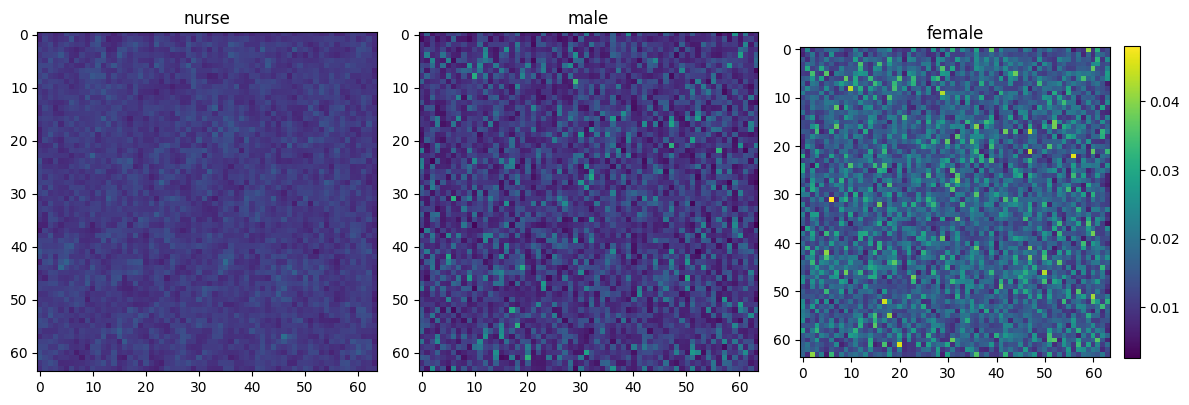

ca map shape: (32, 32)


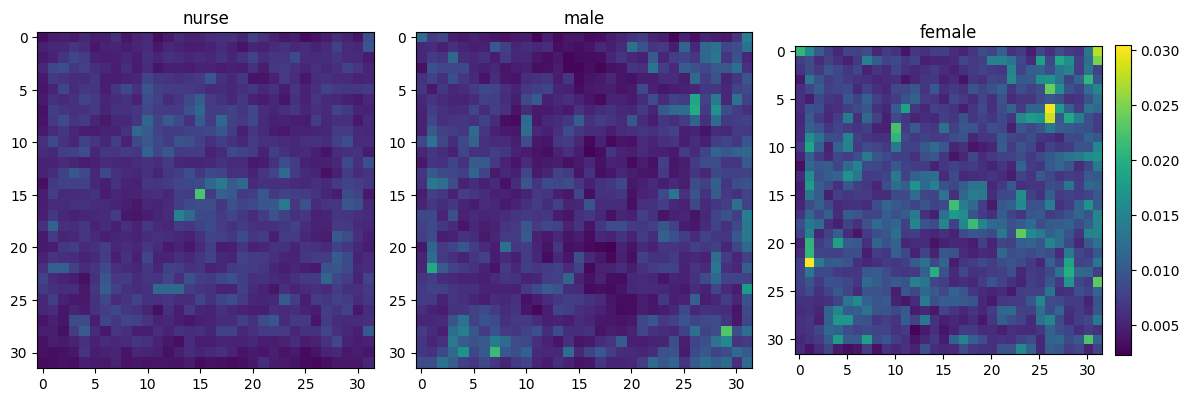

ca map shape: (16, 16)


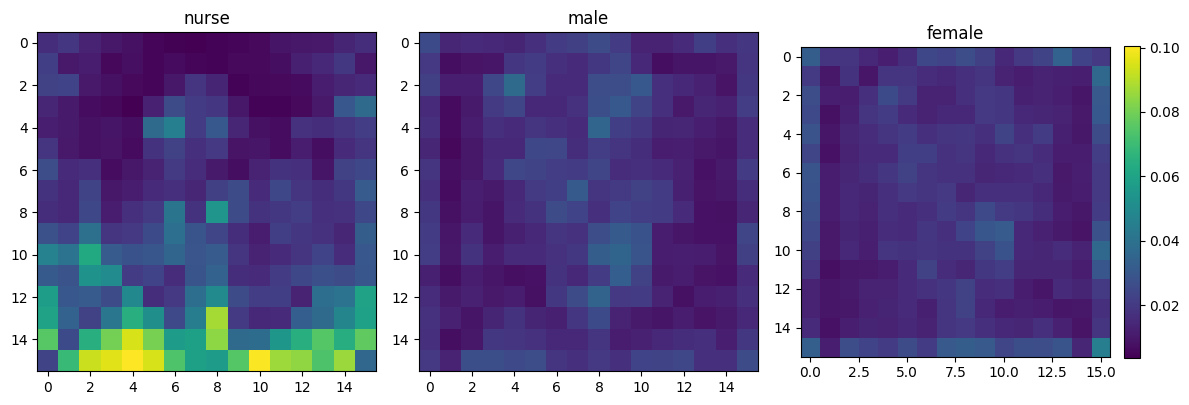

ca map shape: (16, 16)


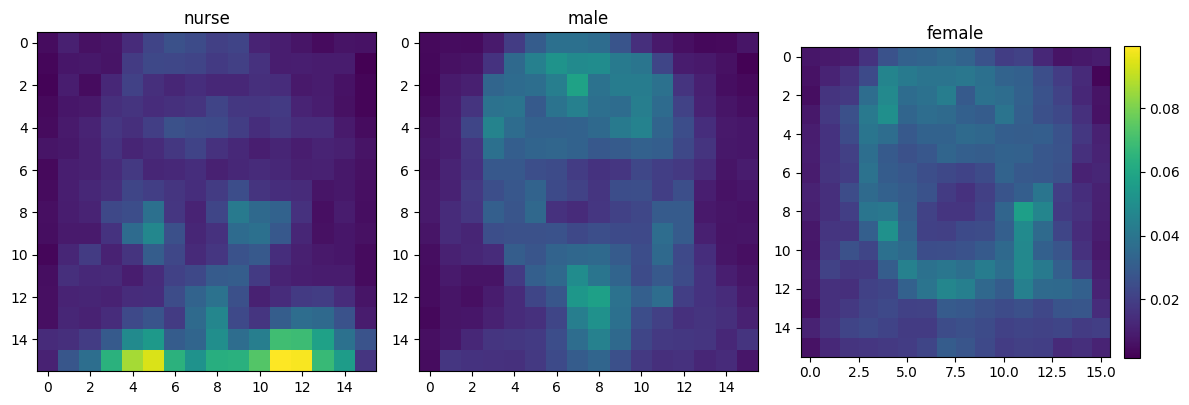

ca map shape: (32, 32)


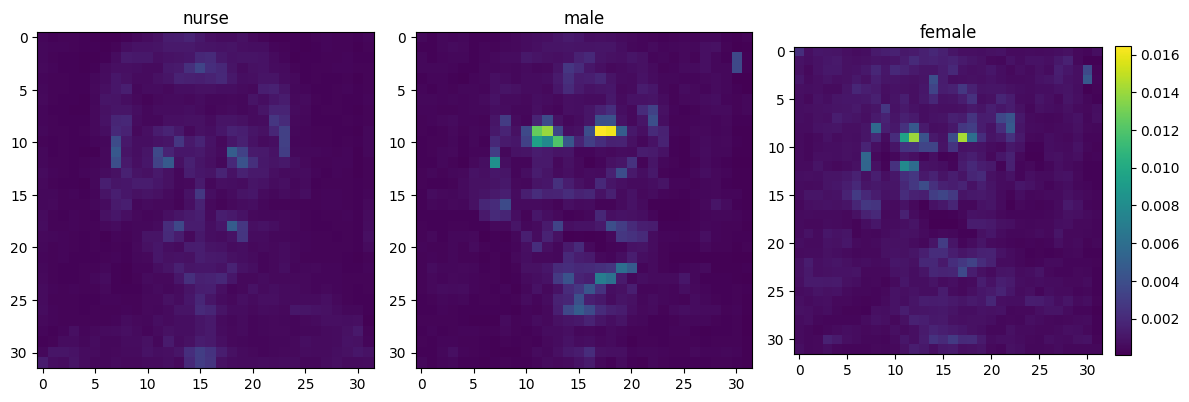

ca map shape: (64, 64)


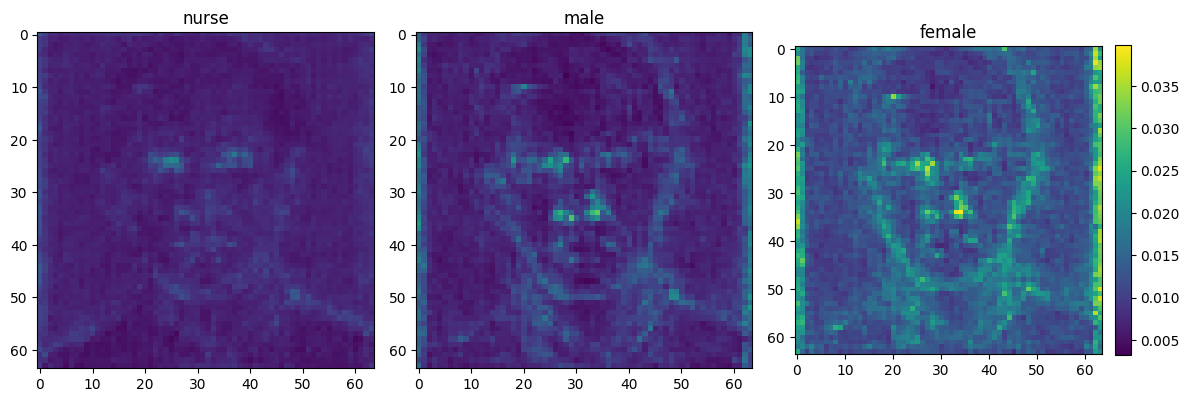

b1: 0.844, 0.000, b2: 0.887, 0.000
mse loss: 0.0
bias loss iter 0: 0.0
bias loss breaking from loss < 0.001
T-SAM loss after BIAS iter refinement: 2.625
updated latent (step 5)
Iter 6, T-SAM attn loss: 2.603515625
updated latent (step 6)
Iter 7, T-SAM attn loss: 2.607421875
updated latent (step 7)
Iter 8, T-SAM attn loss: 2.576171875
updated latent (step 8)
Iter 9, T-SAM attn loss: 2.58984375
updated latent (step 9)
Iter 10, T-SAM attn loss: 2.5703125
Starting bias iterative refinement for step: 10
ca map shape: (64, 64)


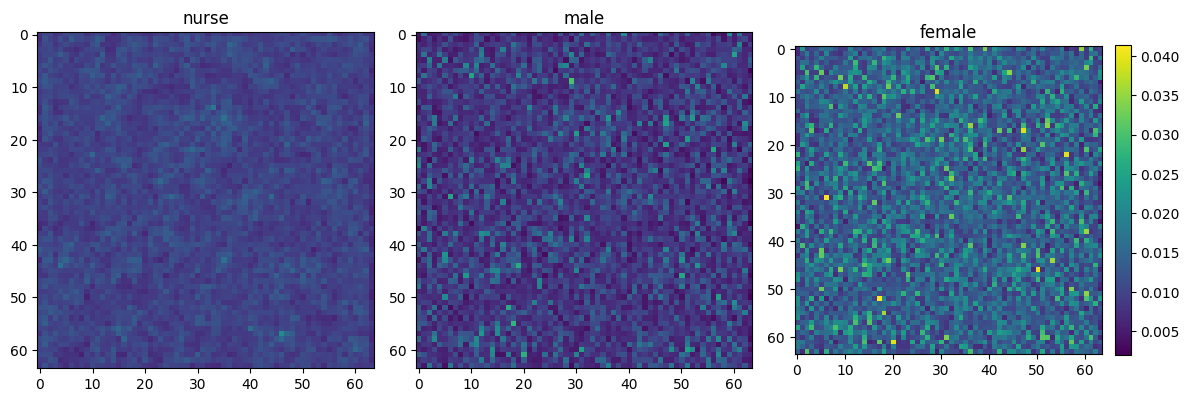

ca map shape: (32, 32)


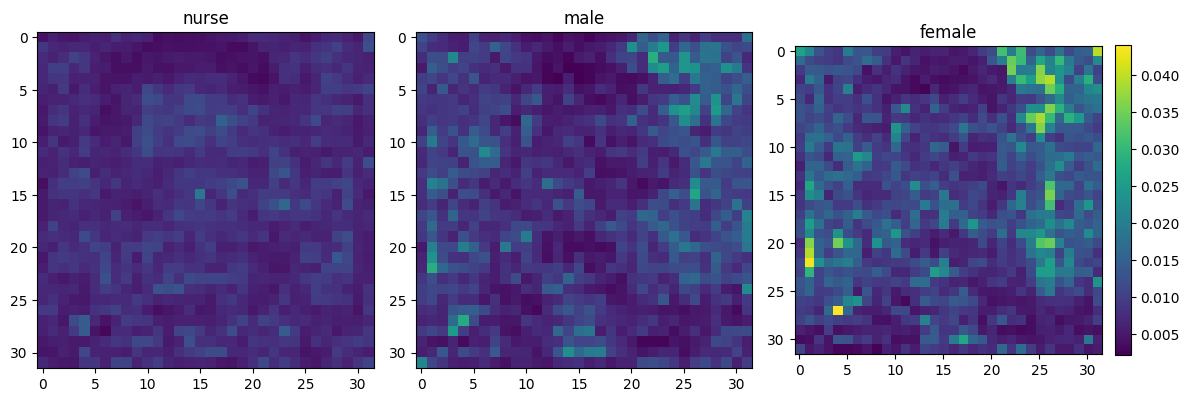

ca map shape: (16, 16)


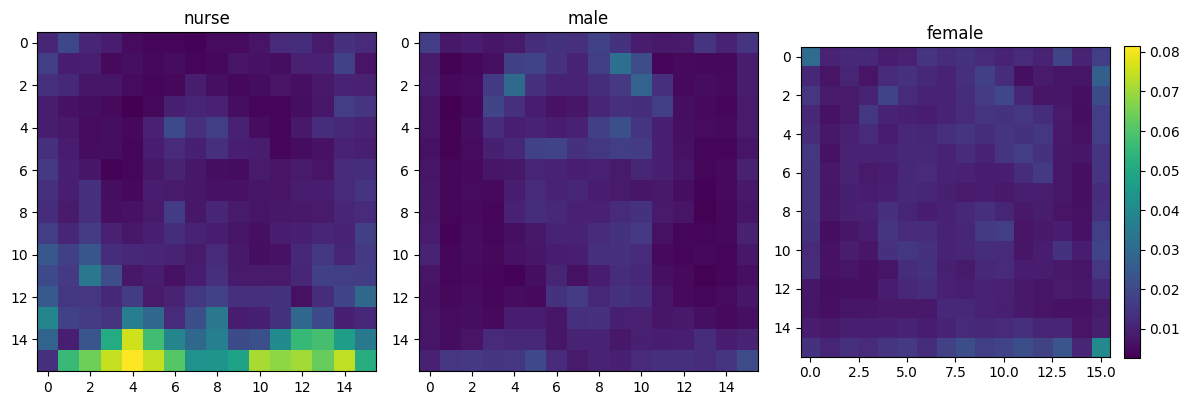

ca map shape: (16, 16)


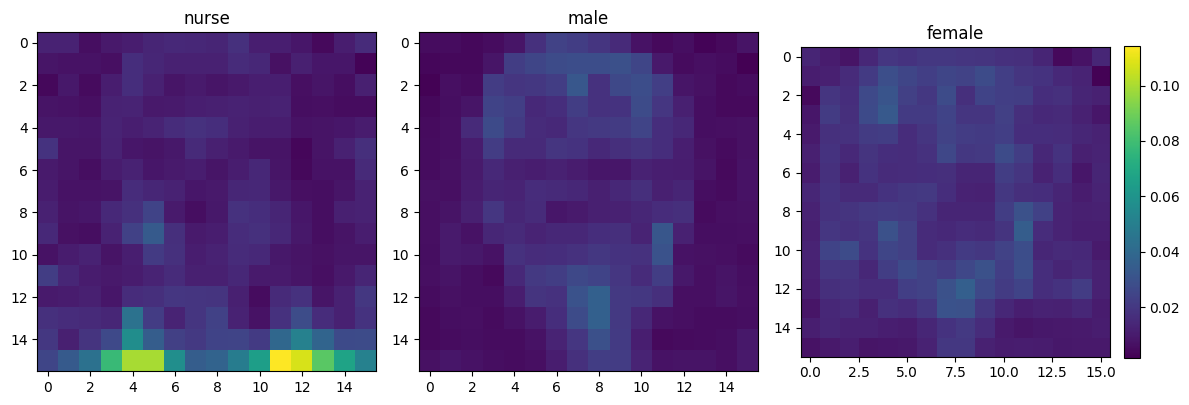

ca map shape: (32, 32)


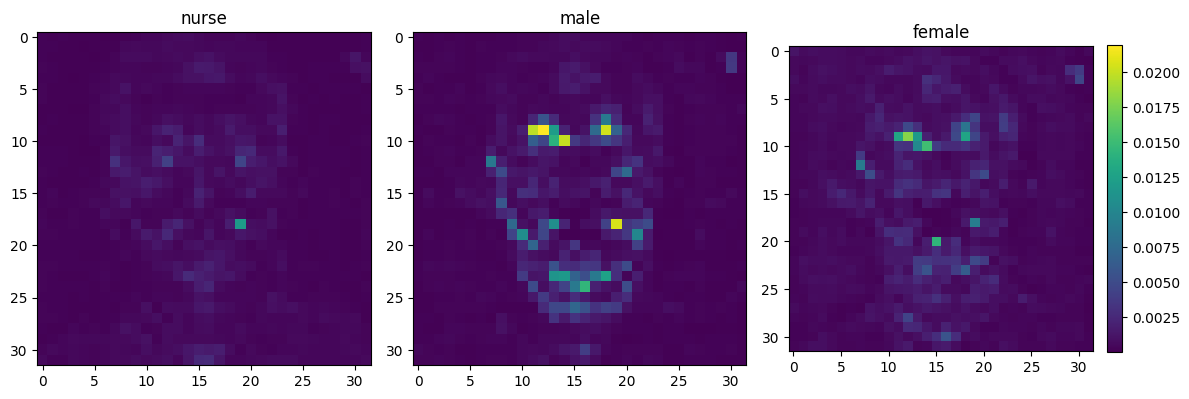

ca map shape: (64, 64)


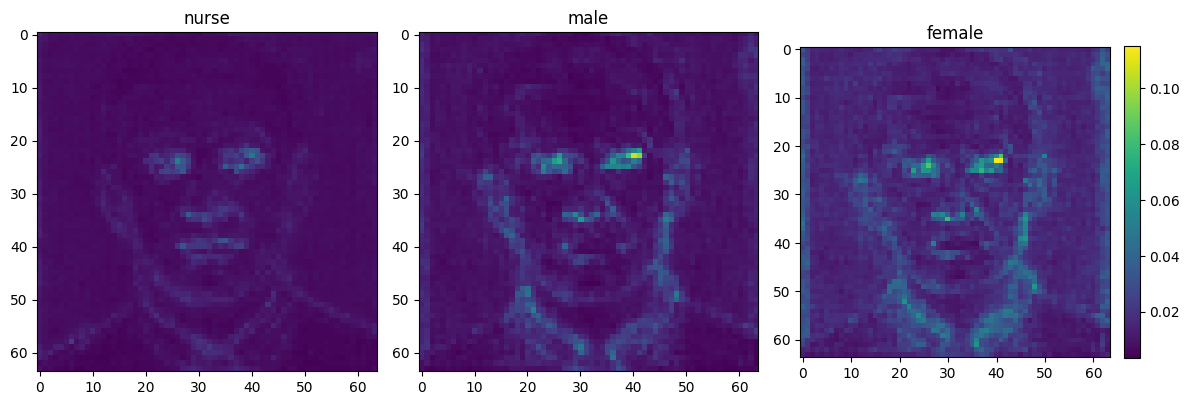

b1: 0.721, 0.000, b2: 0.820, 0.000
mse loss: 0.0
bias loss iter 0: 0.0
bias loss breaking from loss < 0.001
T-SAM loss after BIAS iter refinement: 2.5703125
updated latent (step 10)
Iter 11, T-SAM attn loss: 2.578125
updated latent (step 11)
Iter 12, T-SAM attn loss: 2.5703125
updated latent (step 12)
Iter 13, T-SAM attn loss: 2.568359375
updated latent (step 13)
Iter 14, T-SAM attn loss: 2.560546875
updated latent (step 14)
Iter 15, T-SAM attn loss: 2.5546875
updated latent (step 15)
Iter 16, T-SAM attn loss: 2.544921875
updated latent (step 16)
Iter 17, T-SAM attn loss: 2.53515625
updated latent (step 17)
Iter 18, T-SAM attn loss: 2.5234375
updated latent (step 18)
Iter 19, T-SAM attn loss: 2.5078125
updated latent (step 19)
Iter 20, T-SAM attn loss: 2.48828125
Starting bias iterative refinement for step: 20
ca map shape: (64, 64)


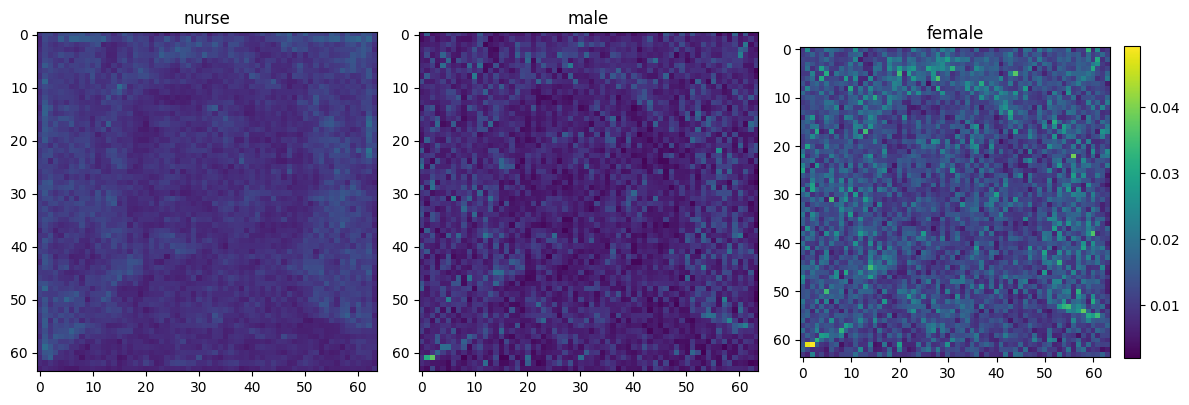

ca map shape: (32, 32)


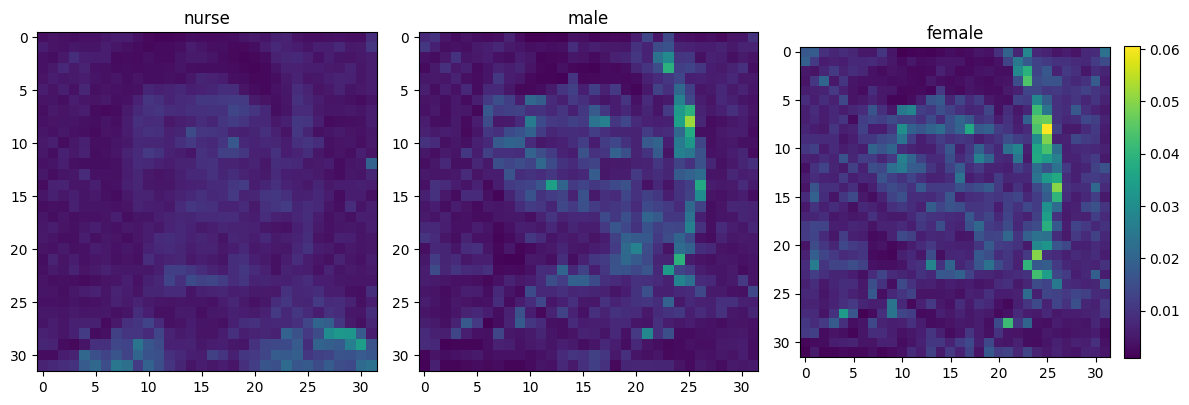

ca map shape: (16, 16)


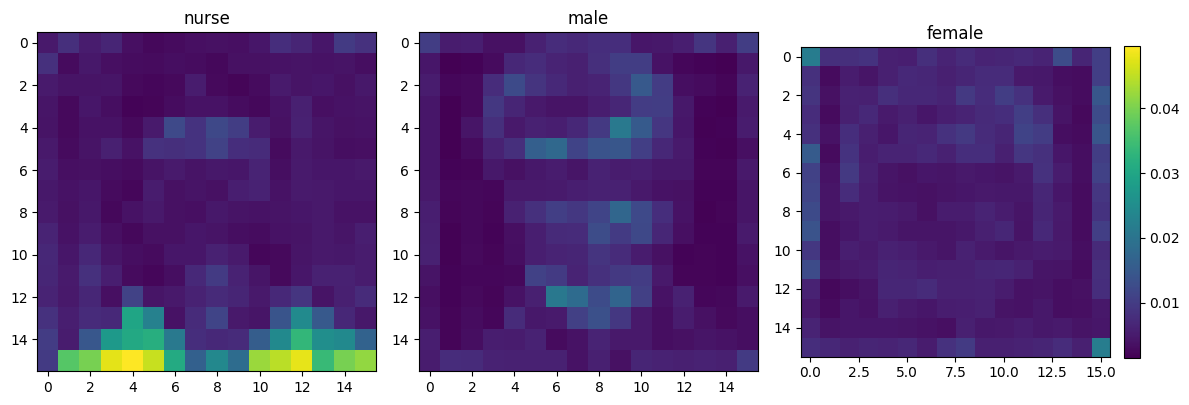

ca map shape: (16, 16)


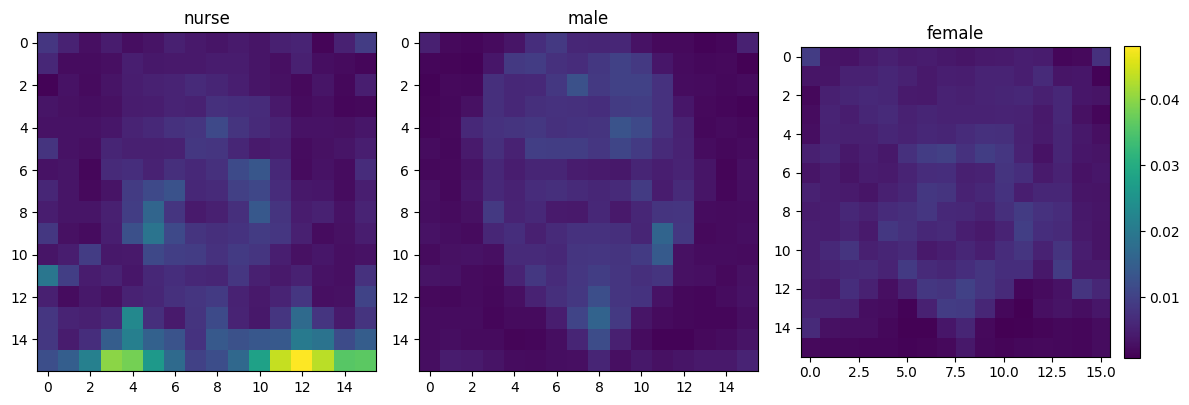

ca map shape: (32, 32)


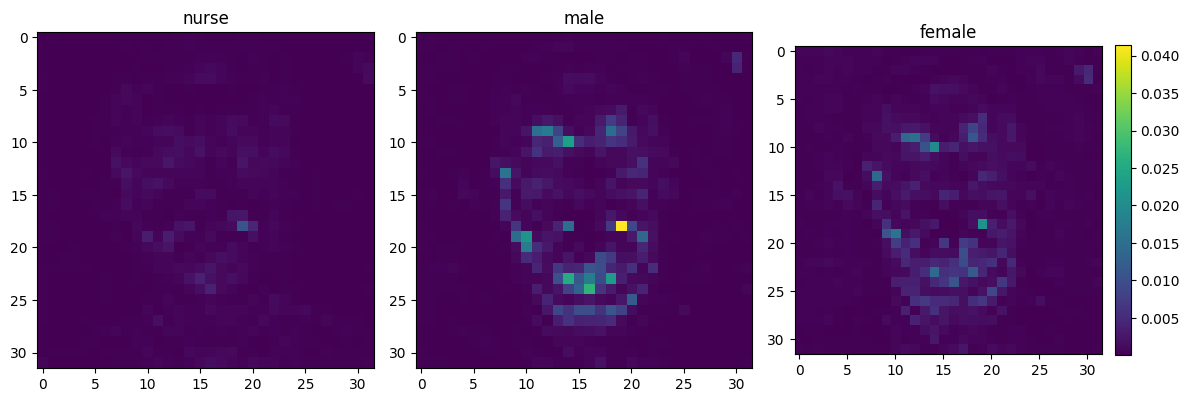

ca map shape: (64, 64)


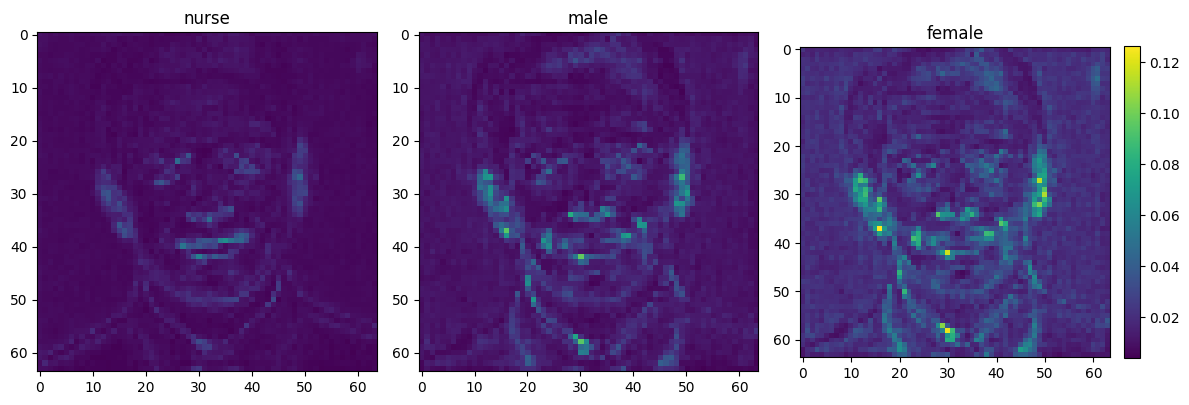

b1: 0.638, 5.961, b2: 0.757, 0.000
mse loss: 0.0
bias loss iter 0: 0.0
bias loss breaking from loss < 0.001
T-SAM loss after BIAS iter refinement: 2.48828125
updated latent (step 20)
Iter 21, T-SAM attn loss: 2.45703125
updated latent (step 21)
Iter 22, T-SAM attn loss: 2.416015625
updated latent (step 22)
Iter 23, T-SAM attn loss: 2.408203125
updated latent (step 23)
Iter 24, T-SAM attn loss: 2.408203125
updated latent (step 24)
Iter 25, T-SAM attn loss: 2.37890625
updated latent (step 25)
Iter 26, T-SAM attn loss: 2.25
updated latent (step 26)
Iter 27, T-SAM attn loss: 2.26953125
updated latent (step 27)
Iter 28, T-SAM attn loss: 2.20703125
updated latent (step 28)
Iter 29, T-SAM attn loss: 2.138671875
updated latent (step 29)
Iter 30, T-SAM attn loss: 2.359375
Starting bias iterative refinement for step: 30
ca map shape: (64, 64)


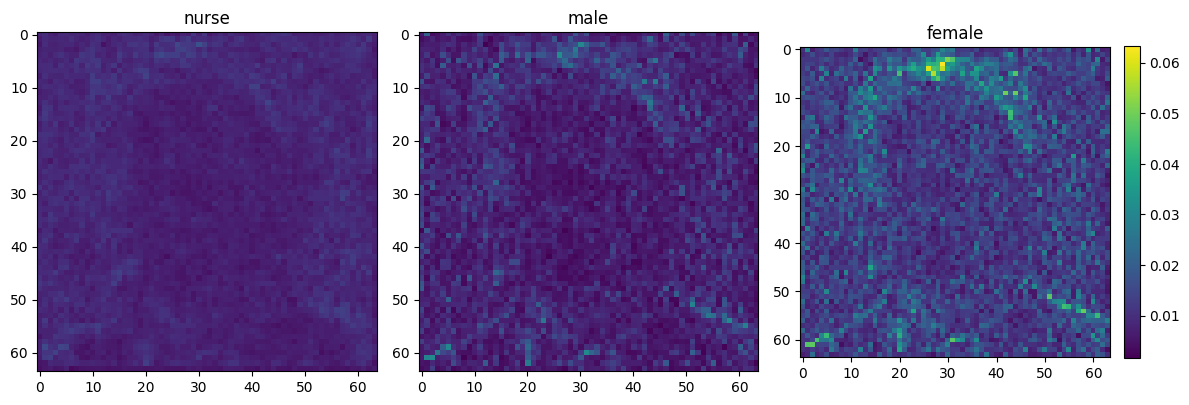

ca map shape: (32, 32)


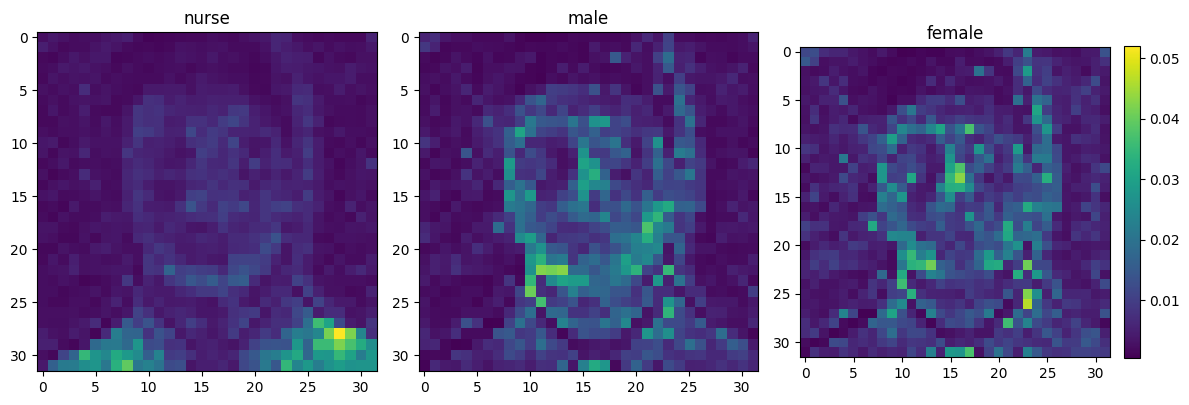

ca map shape: (16, 16)


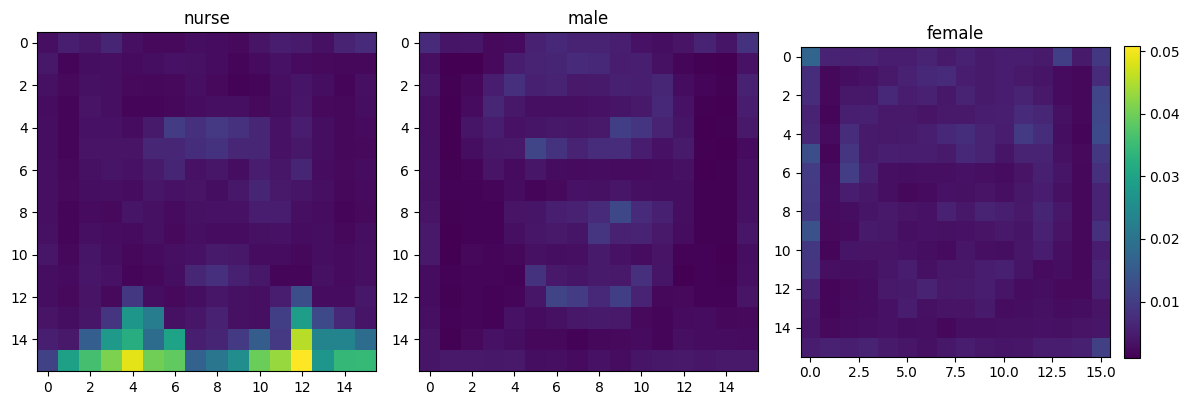

ca map shape: (16, 16)


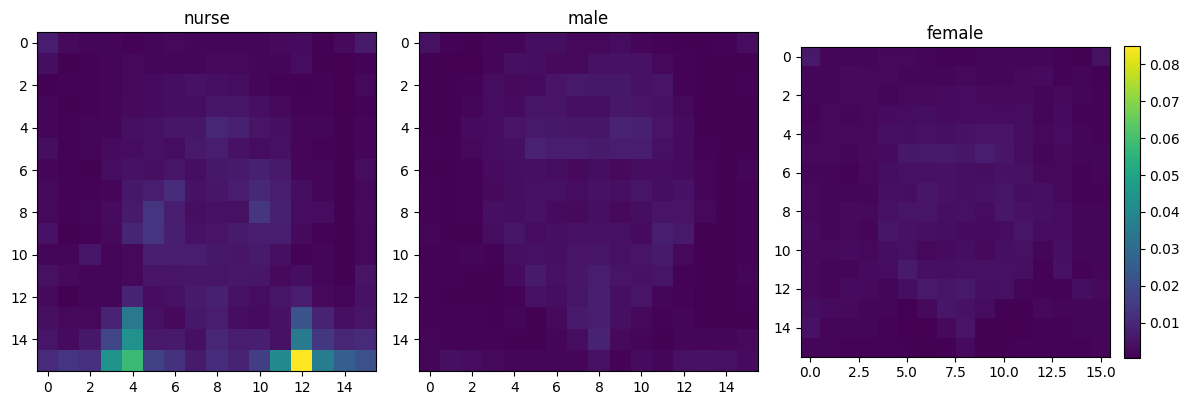

ca map shape: (32, 32)


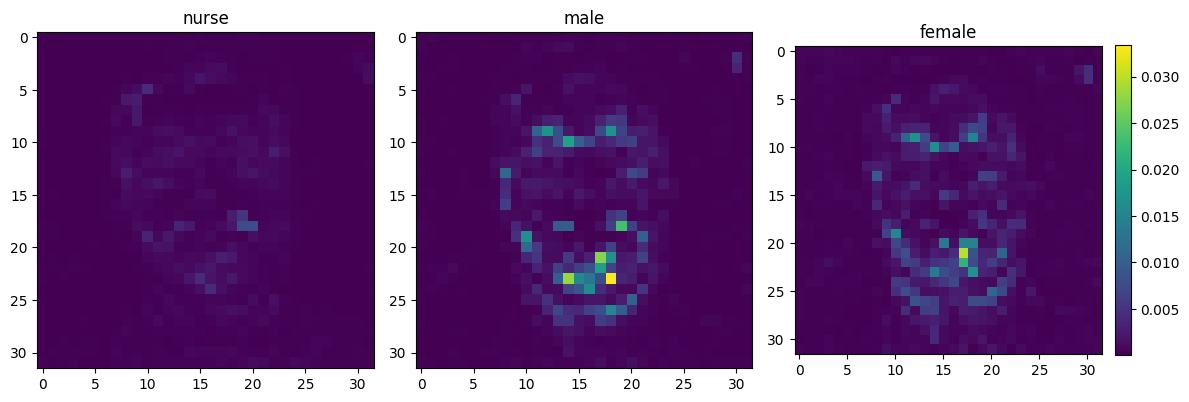

ca map shape: (64, 64)


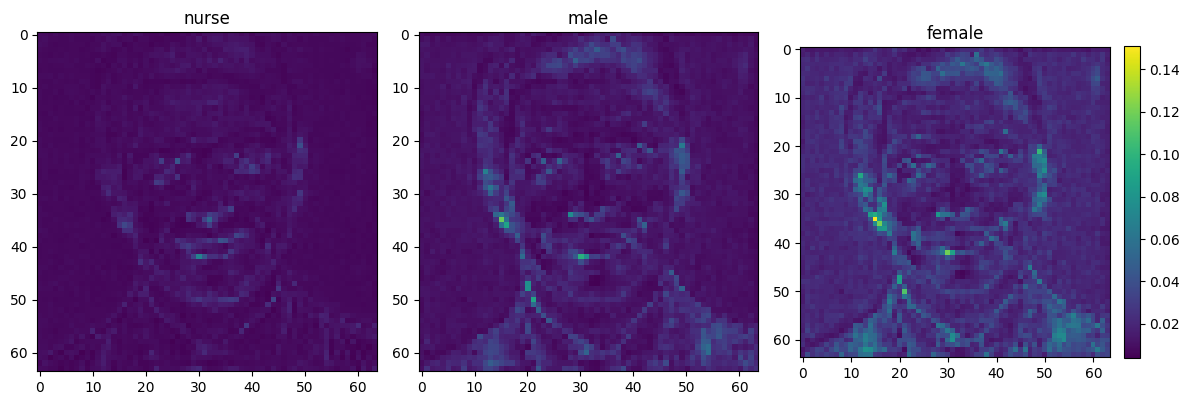

b1: 0.637, 5.961, b2: 0.708, 5.961
mse loss: 0.0
bias loss iter 0: 0.0
bias loss breaking from loss < 0.001
T-SAM loss after BIAS iter refinement: 2.359375
Iter 31, T-SAM attn loss: 2.298828125
Iter 32, T-SAM attn loss: 2.349609375
Iter 33, T-SAM attn loss: 2.3515625
Iter 34, T-SAM attn loss: 2.359375
Iter 35, T-SAM attn loss: 2.361328125
Iter 36, T-SAM attn loss: 2.369140625
Iter 37, T-SAM attn loss: 2.375
Iter 38, T-SAM attn loss: 2.3828125
Iter 39, T-SAM attn loss: 2.38671875
Iter 40, T-SAM attn loss: 2.3984375
Starting bias iterative refinement for step: 40
ca map shape: (64, 64)


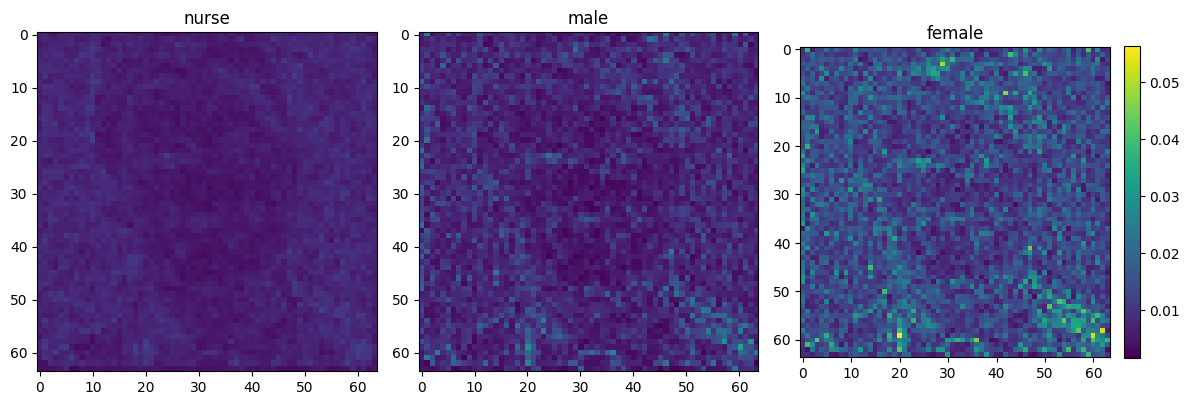

ca map shape: (32, 32)


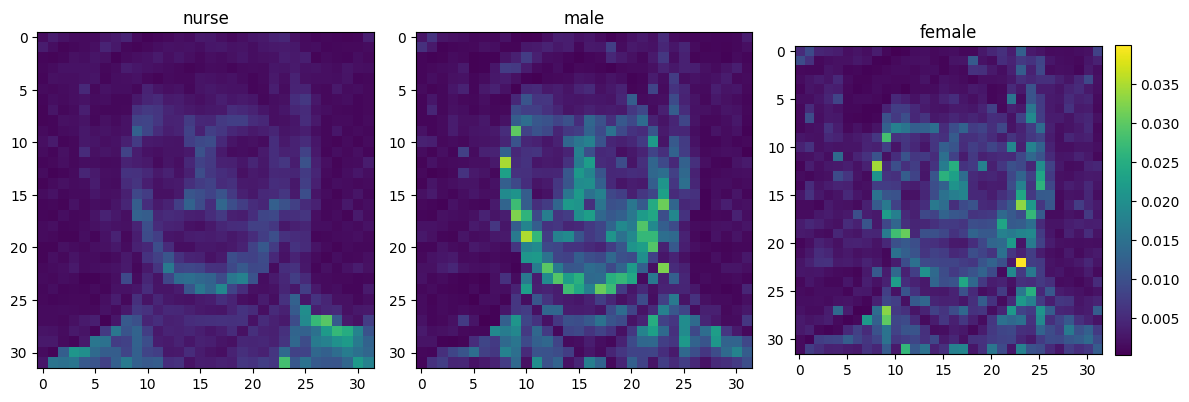

ca map shape: (16, 16)


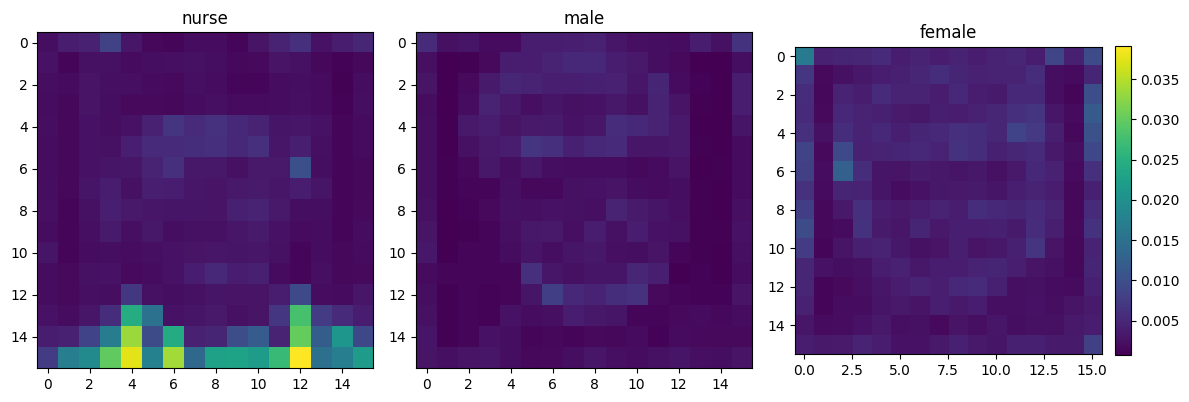

ca map shape: (16, 16)


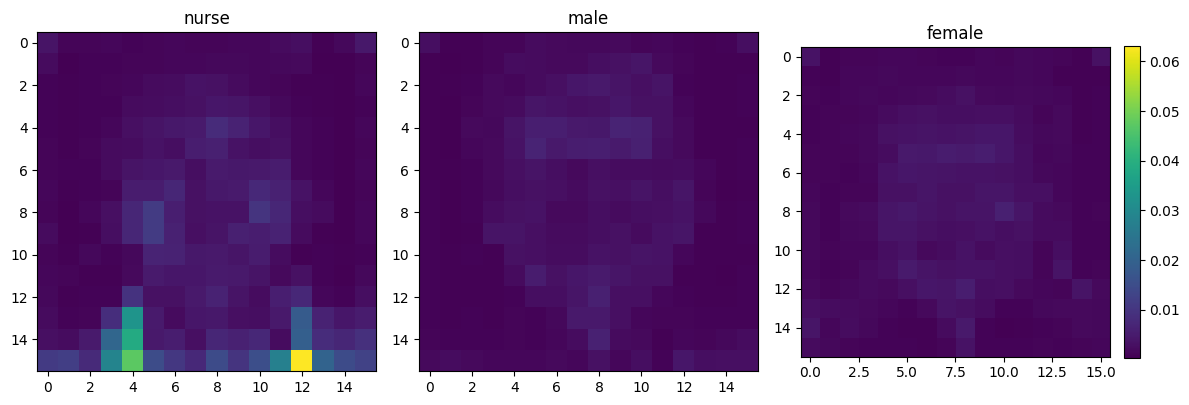

ca map shape: (32, 32)


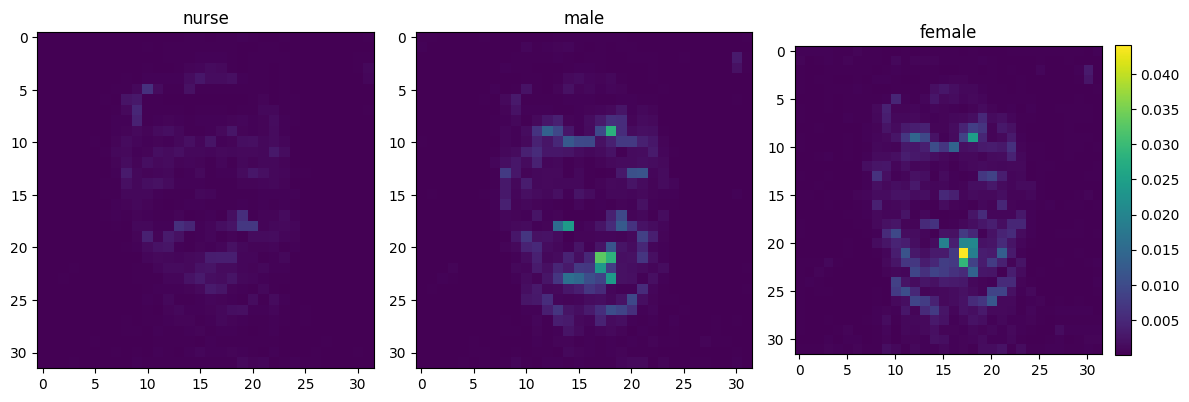

ca map shape: (64, 64)


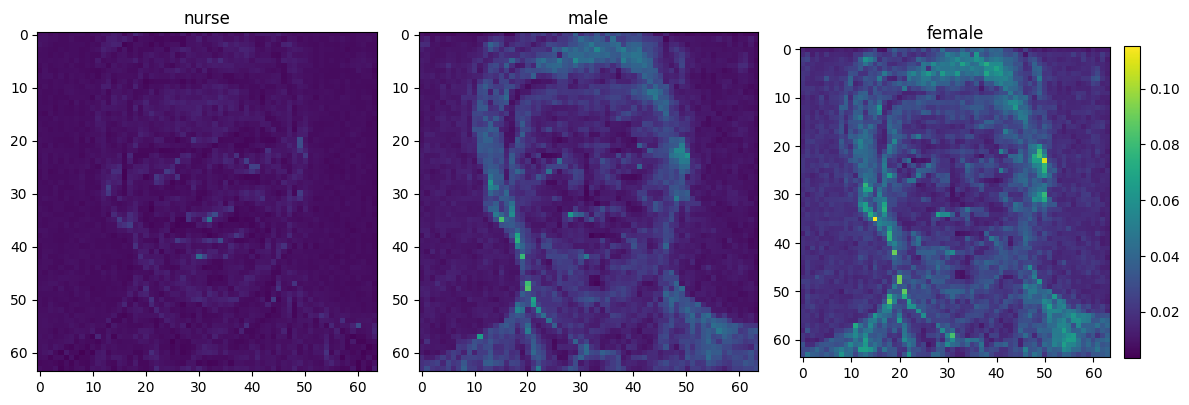

b1: 0.677, 5.961, b2: 0.688, 5.961
mse loss: 0.0
bias loss iter 0: 0.0
bias loss breaking from loss < 0.001
T-SAM loss after BIAS iter refinement: 2.3984375
Iter 41, T-SAM attn loss: 2.404296875
Iter 42, T-SAM attn loss: 2.4140625
Iter 43, T-SAM attn loss: 2.427734375
Iter 44, T-SAM attn loss: 2.443359375
Iter 45, T-SAM attn loss: 2.46484375
Iter 46, T-SAM attn loss: 2.49609375
Iter 47, T-SAM attn loss: 2.529296875
Iter 48, T-SAM attn loss: 2.57421875
Iter 49, T-SAM attn loss: 2.640625
Starting bias iterative refinement for step: 49
ca map shape: (64, 64)


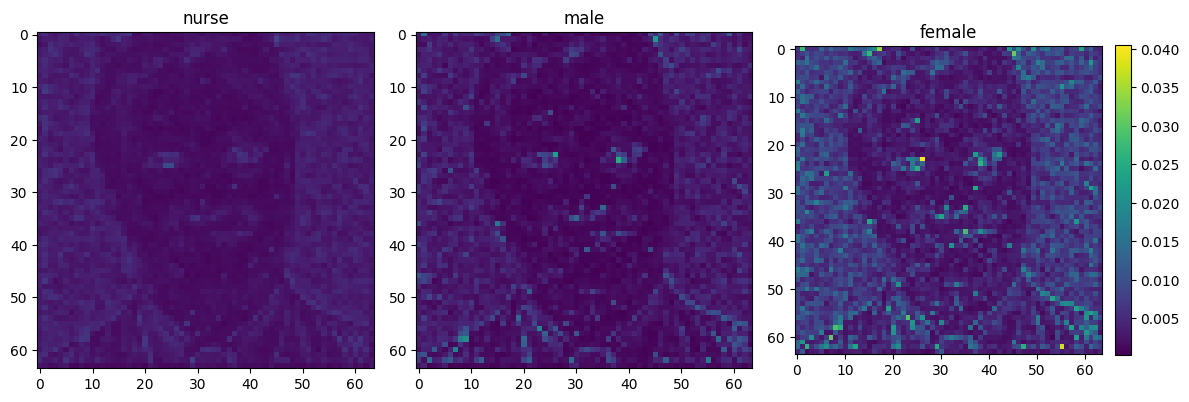

ca map shape: (32, 32)


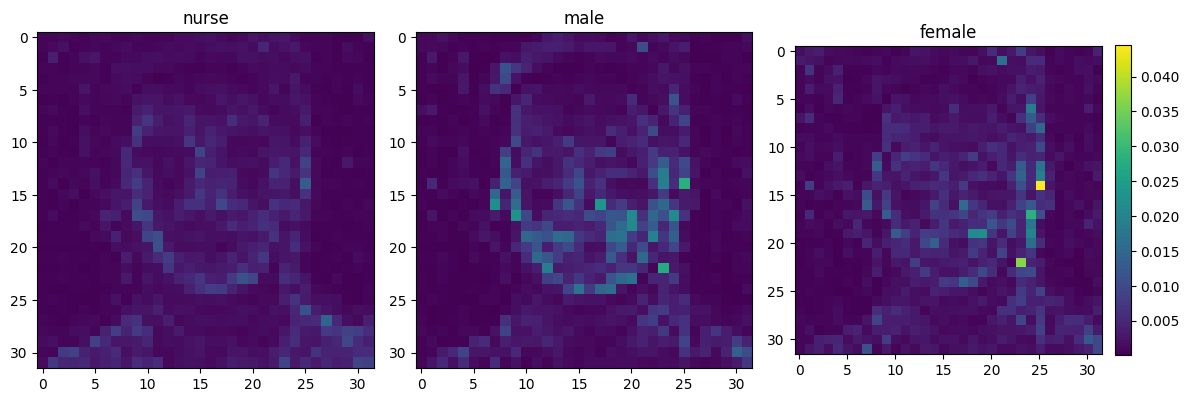

ca map shape: (16, 16)


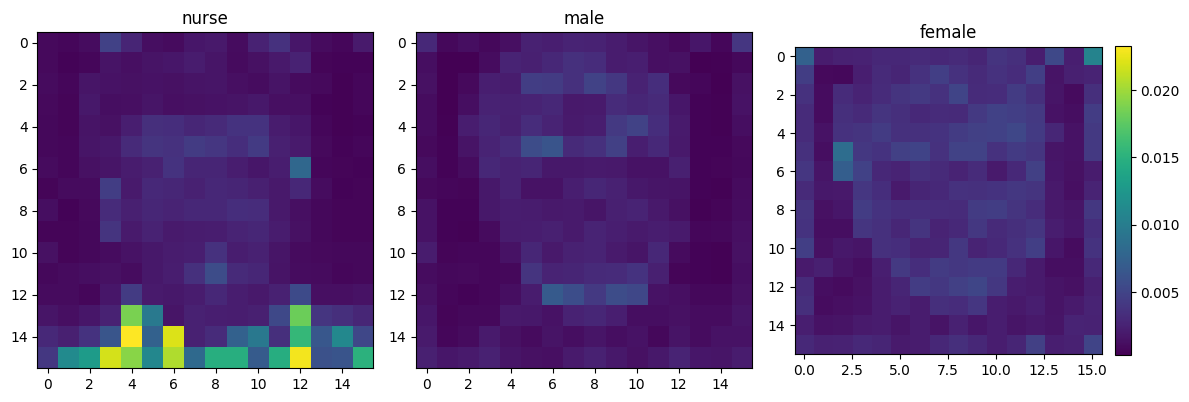

ca map shape: (16, 16)


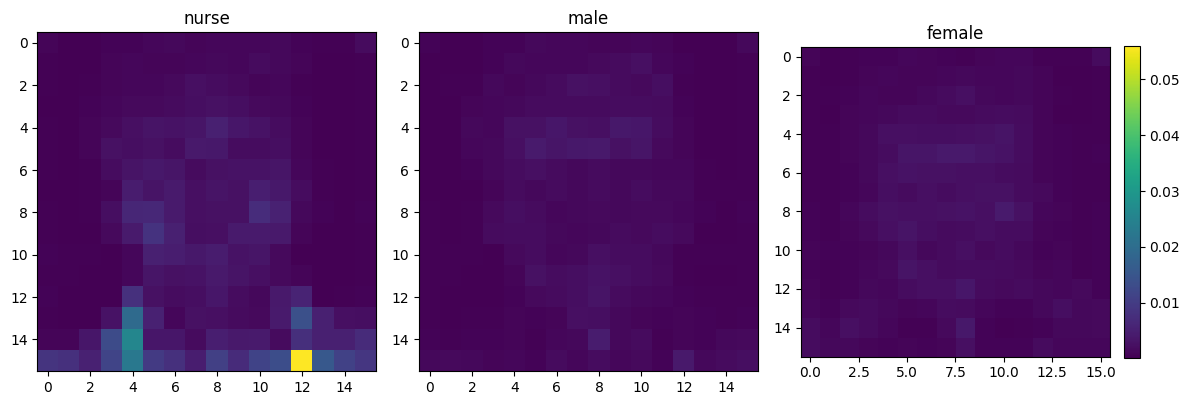

ca map shape: (32, 32)


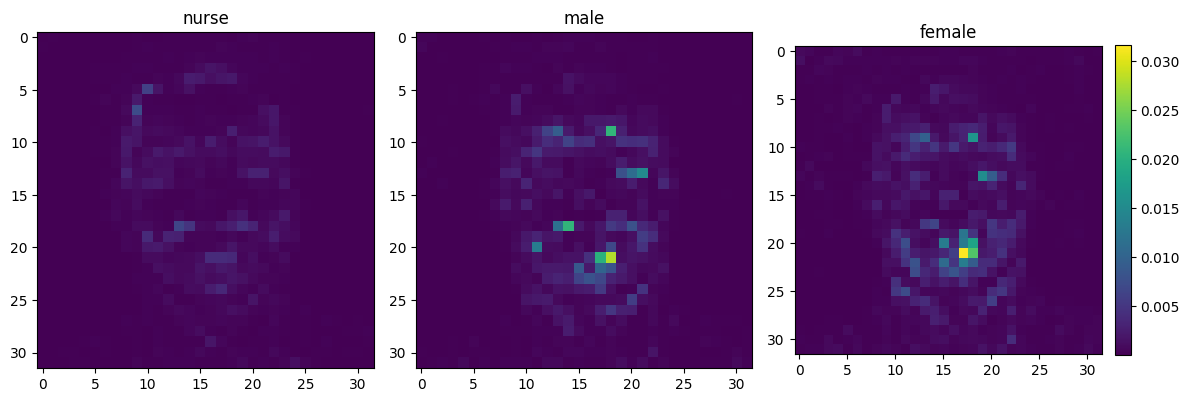

ca map shape: (64, 64)


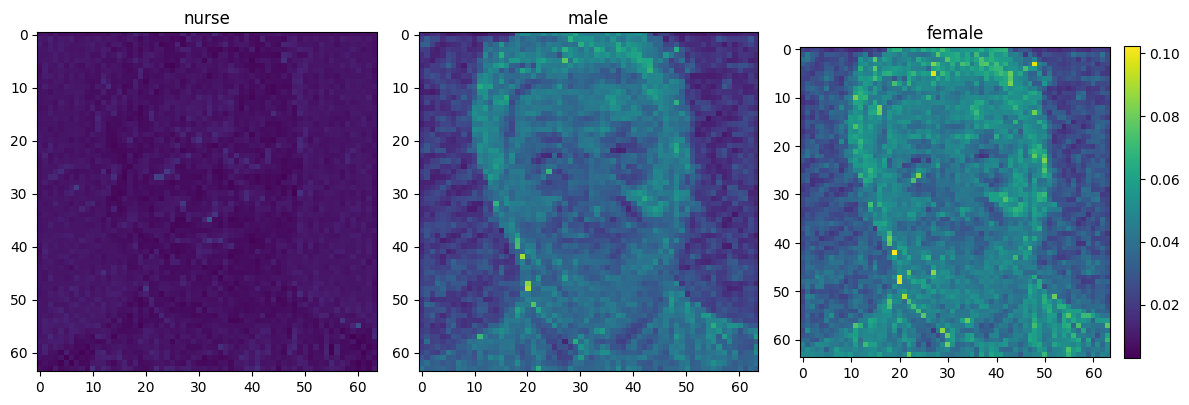

b1: 0.709, 0.000, b2: 0.706, 5.961
mse loss: 0.0
bias loss iter 0: 0.0
bias loss breaking from loss < 0.001
T-SAM loss after BIAS iter refinement: 2.640625
Iter 50, T-SAM attn loss: 2.76953125


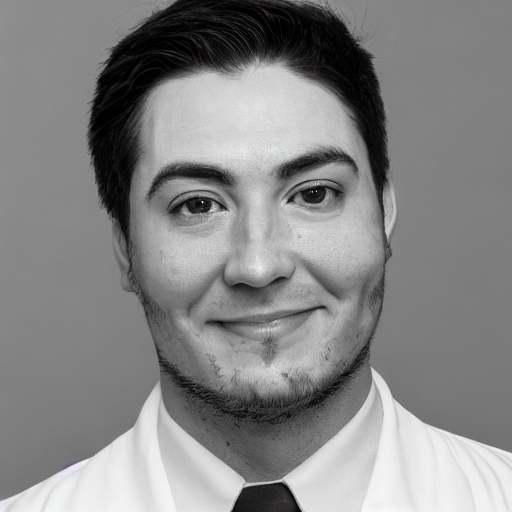

In [ ]:
# disable T-SAM iterative function
latent_opt_config.iterative_refinement_steps = []
# latent_opt_config.max_iter_to_alter=

# bias map display settings
latent_opt_config.show_first_bias_map = True
latent_opt_config.show_last_bias_map = False

# latent_opt_config.bias_refinement_steps = [i+5 for i in range(15)]
latent_opt_config.bias_refinement_steps = [5,10,20,30,40,49]

latent_opt_config.bias_loss_function_details = {'display' : 'all',                      # 'all' or default of one
                                                'separate_scales': False,                # True or default of None/False
                                                'block_class': 'CrossAttnUpBlock2D',    # None, 'CrossAttnUpBlock2D' or 'CrossAttnDownBlock2D'
                                                'total_map_size': 32*32,                #  None, 16*16, 32*32, or 64*64
                                                'max_cnt':5
                                                }
latent_opt_config.bias_loss_threshold = 0.001


main_prompt = "A photo of the face of a male nurse"

occupation_info = {'word' : 'nurse'}

bias_prompt_form = "A photo of a {}"
bias_info = [{'word' : 'male',   'opt_embedding' : male_embed},
             {'word' : 'female', 'opt_embedding' : female_embed}]

image, attention_maps = bias_reduced_generation(main_prompt, occupation_info, bias_prompt_form, bias_info, num_inference_steps=50)
image[0]